# 3.6. Tratamiento de series temporales II.

In [12]:
import pandas as pd
import numpy  as np
import matplotlib as plt
#%matplotlib inline

## Time Series con índices duplicados

- Podemos tener fechas duplicadas en el índice:

In [ ]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000',
                          '1/2/2000', '1/3/2000'])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts

In [ ]:
dup_ts.index.is_unique

In [ ]:
dup_ts['1/3/2000']  # not duplicated

In [ ]:
dup_ts['1/2/2000']  # duplicated

- Para eliminarlos podemos agrupar por nivel 0 y realizar una operación que los unifique.

In [ ]:
grouped = dup_ts.groupby(level=0)
grouped.mean()

In [ ]:
grouped.first()

In [ ]:
grouped.count()

### Date Offsets

In [ ]:
from pandas.tseries.offsets import Hour, Minute

In [ ]:
rango = pd.date_range('2000-01-01', '2000-01-03 23:59', freq='4h')
rango

In [ ]:
rango + Hour(2) + Minute(30)

#### Desplazamiento

- Existen dos métodos principales: ``shift()`` and ``tshift()``
 * ``shift()`` desplaza los datos.
 * ``tshift()`` desplaza el índice.
- En ambos casos, se especifica por la frecuencia.

In [ ]:
dates = pd.date_range('2015-07-25', periods=15, freq='B')
data = pd.DataFrame({'close':[10,12,14,15,15,19, 20,17, 15, 14, 12,13,13,14,10]}, index=dates)
data

In [ ]:
data.shift(5)

In [ ]:
data.tshift(5)

## Remuestreo
- La indexación de Pandas permite operaciones de remuestreo con relativa facilidad. 
- Es común necesitar obtener los datos a mayor o menor frecuencia de la disponible.
- Para ello se puede usar ``resample()`` o ``asfreq()`` (más sencillo).
- La diferencia principal es que mientras la primera es una agregación de datos, la segunda es una selección de los mismos. 

In [ ]:
rng = pd.date_range('2000-01-01', periods=100, freq='D')
ts = pd.DataFrame(np.random.randn(len(rng)), index=rng)
ts

In [ ]:
ts.resample('M').mean()

In [ ]:
ts.resample('BM').mean()

- Mientras que ``resample()`` devuelve la media del periodo
- ``asfreq()`` devuelve el último valor (omitiendo el mes en caso de no existir).
- Una ventaja adicional de ``asfreq()`` es la capacidad de imputar valores.

In [ ]:
ts.asfreq('5D')

### Downsampling

In [ ]:
rng = pd.date_range('2000-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)
ts

In [ ]:
ts.resample('5min').sum()

In [ ]:
ts.resample('5min', closed='right').sum()

In [ ]:
ts.resample('5min', closed='right', label='right').sum()

### Open-High-Low-Close (OHLC) resampling

In [ ]:
ts

In [ ]:
ts.resample('5min').ohlc()

### Upsampling e Interpolation

In [ ]:
frame = pd.DataFrame(np.random.randn(2, 4),
                     index=pd.date_range('1/1/2000', periods=2,
                                         freq='W-WED'),
                     columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame

In [ ]:
df_daily = frame.resample('D').asfreq()
df_daily

In [ ]:
frame.resample('D').ffill()

In [ ]:
frame.resample('D').ffill(limit=2)

## Ventanas móviles

- Se utiliza la función ``rolling()``, que funciona de forma similar a ``groupby``.
- Con distintas operaciones de agregación disponibles.

In [9]:
close_px_all = pd.read_csv('test_data/stock_px_2.csv',
                           parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px.head()

,AAPL,MSFT,XOM
2003-01-02,7.40,21.11,29.22
2003-01-03,7.45,21.14,29.24
2003-01-06,7.45,21.52,29.96
2003-01-07,7.43,21.93,28.95
2003-01-08,7.28,21.31,28.83


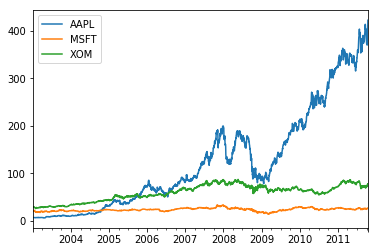

In [23]:
close_px.plot()

In [10]:
close_px = close_px.resample('B').ffill()
close_px

,AAPL,MSFT,XOM
2003-01-02,7.40,21.11,29.22
2003-01-03,7.45,21.14,29.24
2003-01-06,7.45,21.52,29.96
2003-01-07,7.43,21.93,28.95
2003-01-08,7.28,21.31,28.83
2003-01-09,7.34,21.93,29.44
2003-01-10,7.36,21.97,29.03
2003-01-13,7.32,22.16,28.91
2003-01-14,7.30,22.39,29.17
2003-01-15,7.22,22.11,28.77


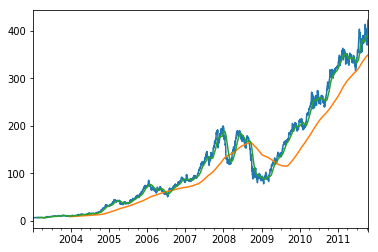

In [30]:
close_px.AAPL.plot()
close_px.AAPL.rolling(250).mean().plot()
close_px.AAPL.rolling(30).mean().plot()

In [31]:
appl_std250 = close_px.AAPL.rolling(250, min_periods=10).std()
appl_std250[5:12]

2003-01-09         NaN
2003-01-10         NaN
2003-01-13         NaN
2003-01-14         NaN
2003-01-15    0.077496
2003-01-16    0.074760
2003-01-17    0.112368
Freq: B, Name: AAPL, dtype: float64

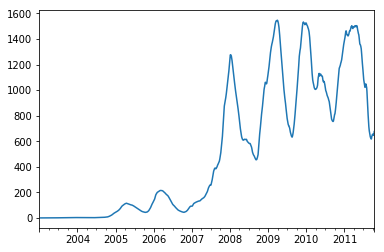

In [26]:
appl_std250.plot()

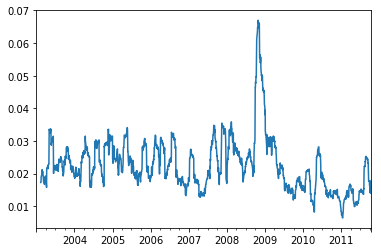

In [29]:
std_ret = close_px.AAPL.pct_change().rolling(30).std()
std_ret.plot()

- Ventanas que se expanden en su tamaño cada elemento.

In [37]:
expanding_mean = close_px.AAPL.expanding().max()

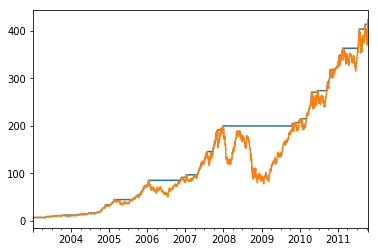

In [38]:
expanding_mean.plot()
close_px.AAPL.plot()

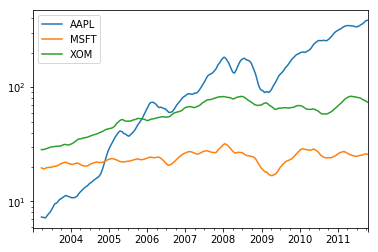

In [39]:
close_px.rolling(60).mean().plot(logy=True)

In [40]:
close_px.rolling('20D').mean()

,AAPL,MSFT,XOM
2003-01-02,7.400000,21.110000,29.220000
2003-01-03,7.425000,21.125000,29.230000
2003-01-06,7.433333,21.256667,29.473333
2003-01-07,7.432500,21.425000,29.342500
2003-01-08,7.402000,21.402000,29.240000
2003-01-09,7.391667,21.490000,29.273333
2003-01-10,7.387143,21.558571,29.238571
2003-01-13,7.378750,21.633750,29.197500
2003-01-14,7.370000,21.717778,29.194444
2003-01-15,7.355000,21.757000,29.152000


In [43]:
close_px.AAPL.resample('Y').ohlc()

,open,high,low,close
2003-12-31,7.40,12.41,6.56,10.69
2004-12-31,10.69,34.22,10.64,32.20
2005-12-31,31.65,74.98,31.65,71.89
2006-12-31,71.89,91.81,50.67,84.84
2007-12-31,84.84,199.83,83.27,198.08
2008-12-31,198.08,198.08,80.49,85.35
2009-12-31,85.35,211.64,78.20,210.73
2010-12-31,210.73,325.47,192.05,322.56
2011-12-31,329.57,422.00,315.32,422.00


### Exponentially Weighted

In [48]:
aapl_px = close_px.AAPL['2006']
ma60 = aapl_px.rolling(30, min_periods=20).mean()
ewma60 = aapl_px.ewm(span=30).mean()

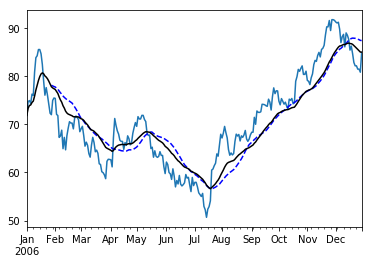

In [49]:
aapl_px.plot()
ma60.plot(style='b--', label='Simple MA')
ewma60.plot(style='k-', label='EW MA')

### Binary Moving Window

In [50]:
spx_px = close_px_all['SPX']
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()

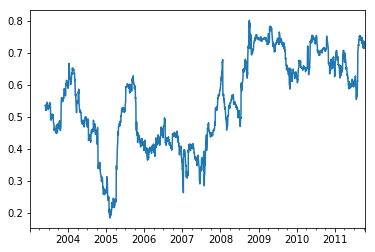

In [51]:
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

In [ ]:
plt.figure()

In [ ]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()